In [1]:
## Examination of filtering



In [35]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import nilearn.plotting


In [31]:
basedir = '/data/brainsss/processed/fly_001/func_0'
origfile = os.path.join(basedir, 'imaging/functional_channel_2.nii')
mocofile = os.path.join(basedir, 'preproc/functional_channel_2_moco.h5')
hpffile = os.path.join(basedir, 'preproc/functional_channel_2_moco_hpf.h5')
maskfile = os.path.join(basedir, 'preproc/functional_channel_2_moco_hpf_mask.nii')
meanfile = os.path.join(basedir, 'preproc/functional_channel_2_moco_hpf_mean.nii')

if 0:
    basedir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_134/func_0'
    origfile = os.path.join(basedir, 'imaging/functional_channel_2.nii')
    mocofile = os.path.join(basedir, 'moco/functional_channel_2_moco.h5')
    hpffile = os.path.join(basedir, 'functional_channel_2_moco_zscore_highpass.h5')

orig = nib.load(origfile).dataobj


In [4]:
m = h5py.File(mocofile, 'r') 
moco = m['data']

In [5]:
# voxel with high signal: 38 60 29 or 232 89 32
# voxel with low_signal: 139 78 32
voxels = {
    'high': [232, 89, 32],
    'low': [139, 78, 32]
}


In [6]:
voxel_to_use = 'high'

x, y, z = voxels[voxel_to_use]




In [7]:
def plot_timeseries(voxel, linewidth = .2):
    """voxel is a list with xyz coordinates"""
    x, y, z = voxel
    origdata = orig[x, y, z, :]
    with h5py.File(mocofile, 'r') as f:
        mocodata = f['data'][x, y, z, :]

    with h5py.File(hpffile, 'r') as f:
        hpfdata = f['data'][x, y, z, :]
        x, y, z = voxel


    plt.figure(figsize=(10,12))
    plt.subplot(311)
    plt.plot(origdata, linewidth=linewidth)
    plt.title(f'original data - {voxel}')
    plt.subplot(312)
    plt.plot(mocodata, linewidth=linewidth)
    plt.title(f'moco data - {voxel}')
    plt.subplot(313)
    plt.plot(hpfdata, linewidth=linewidth)
    plt.title(f'hpf data - {voxel}')

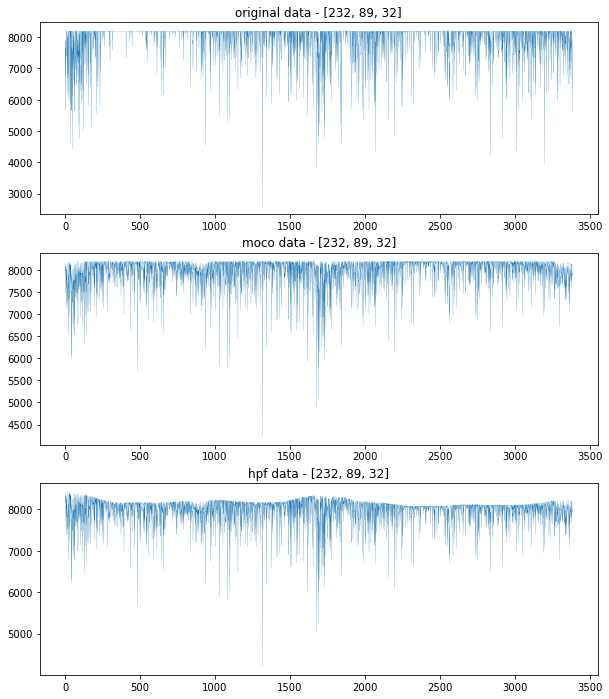

In [8]:
plot_timeseries(voxels['high'])

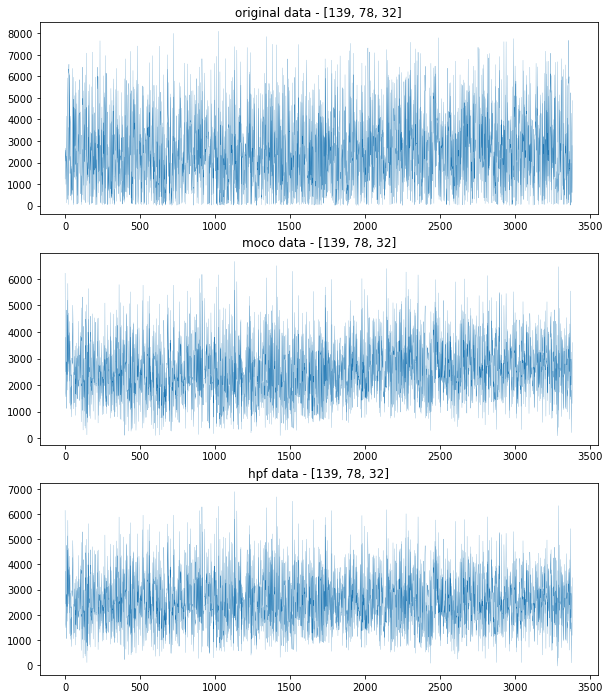

In [9]:
plot_timeseries(voxels['low'])

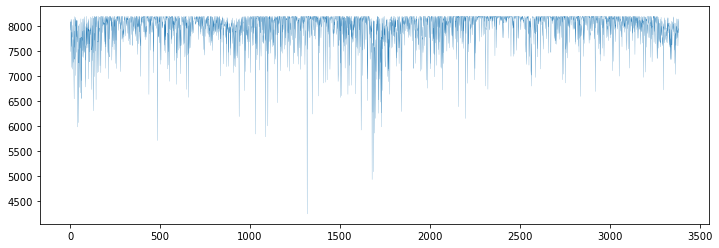

In [10]:
## assess impact of transformation to reduce skewness

voxel_to_use = 'high'
x, y, z = voxels[voxel_to_use]

with h5py.File(mocofile, 'r') as f:
    moco_ts = f['data'][x, y, z, :]

plt.figure(figsize=(12, 4))

plt.plot(moco_ts, linewidth=.2)

In [11]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(standardize=False)

moco_ts_trans = pt.fit_transform(moco_ts.reshape(-1, 1))

/home/poldrack/anaconda3/envs/brainsss/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/poldrack/anaconda3/envs/brainsss/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [12]:
_ = plt.hist(, 500)

SyntaxError: invalid syntax (2904720876.py, line 1)

In [ ]:
import sys
sys.path.append('../scripts')
from imgskewness import imgskewness

skew = imgskewness(mocofile)

In [ ]:
np.mean(moco_ts == np.max(moco_ts))

In [ ]:
# assess autocorrelation

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
voxel_to_use = 'high'
x, y, z = voxels[voxel_to_use]

with h5py.File(mocofile, 'r') as f:
    moco_ts = f['data'][x, y, z, :]
plot_acf(moco_ts)

In [25]:
# PCA
from sklearn.decomposition import IncrementalPCA
maskimg = nib.load(maskfile)

maskvox = (maskimg.get_fdata() > 0).astype('bool')

with h5py.File(mocofile, 'r') as f:
    maskdata = np.zeros((np.sum(maskvox), f['data'].shape[-1]))
    for i in range(f['data'].shape[-1]):
        tpdata = f['data'][:,  :, :, i]
        maskdata[:, i] = tpdata[maskvox]


In [26]:
maskdata.shape

(746639, 3384)

In [27]:
pca = IncrementalPCA(50)
factors = pca.fit_transform(maskdata)

In [28]:
factors.shape

(746639, 50)

/home/poldrack/anaconda3/envs/brainsss/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


KeyboardInterrupt: 

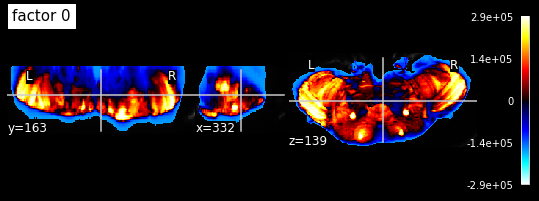

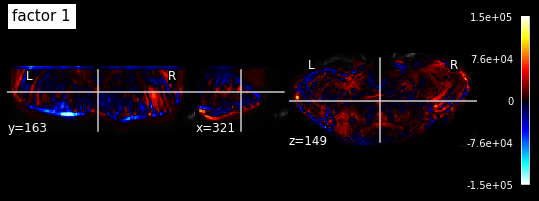

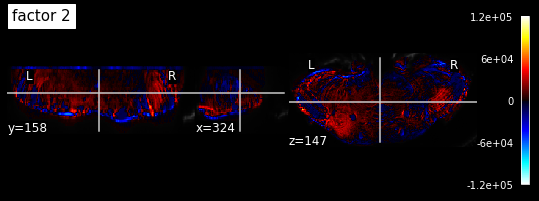

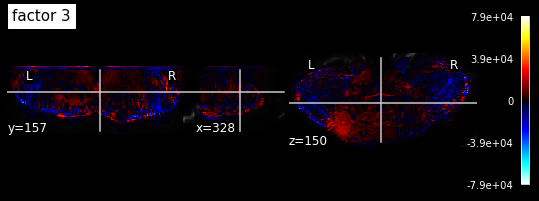

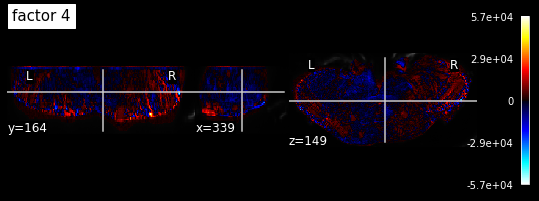

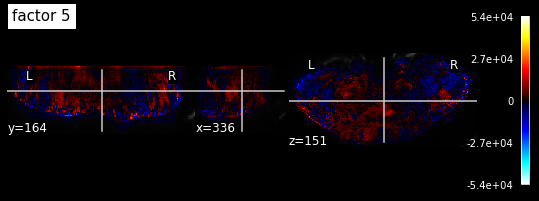

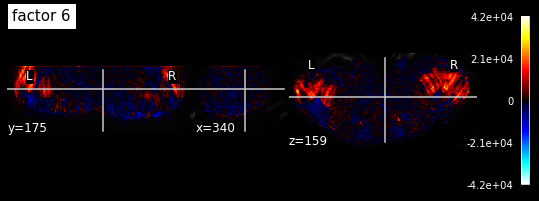

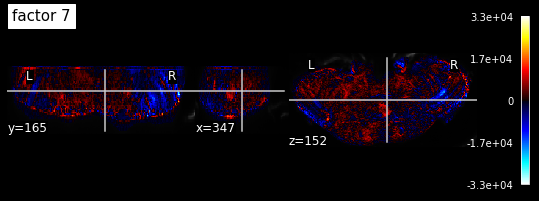

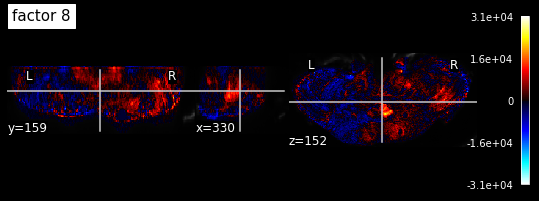

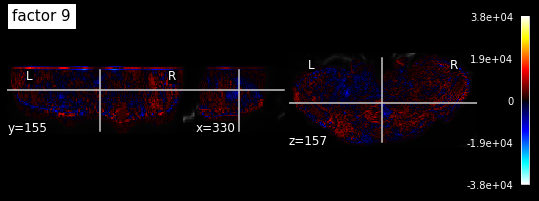

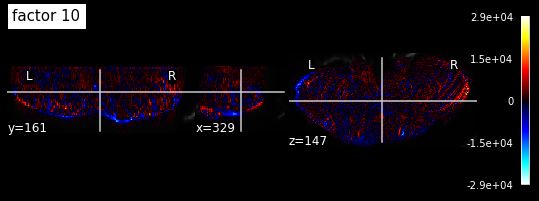

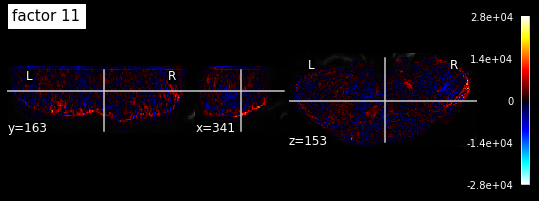

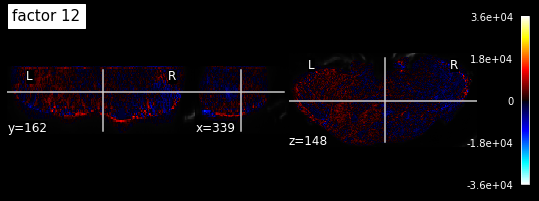

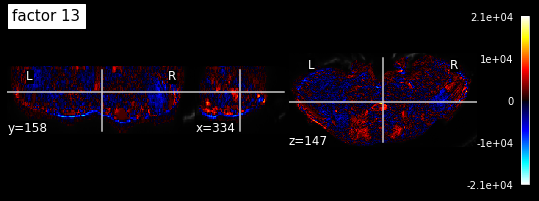

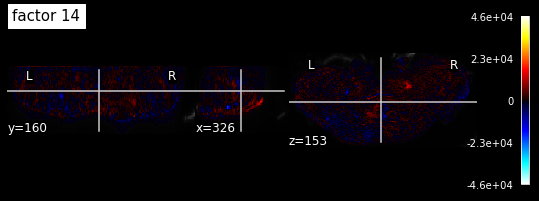

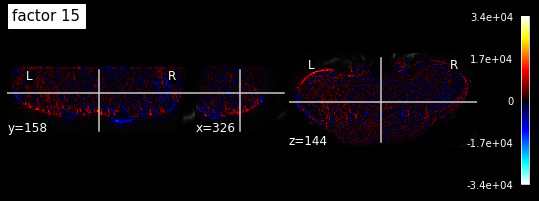

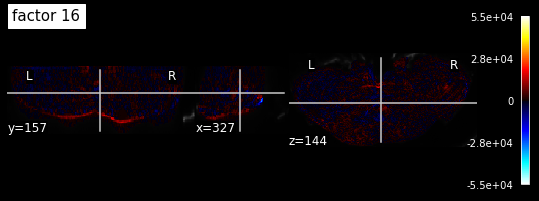

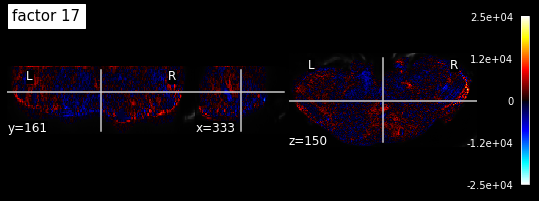

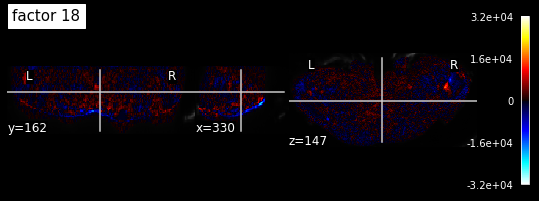

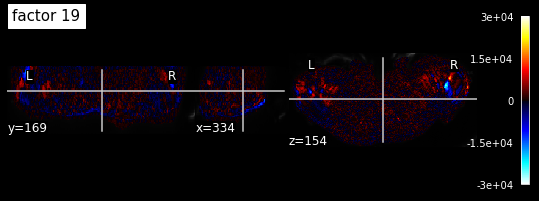

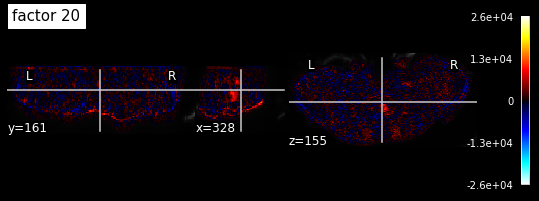

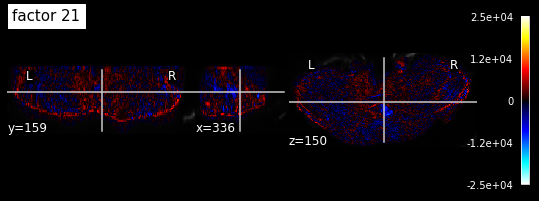

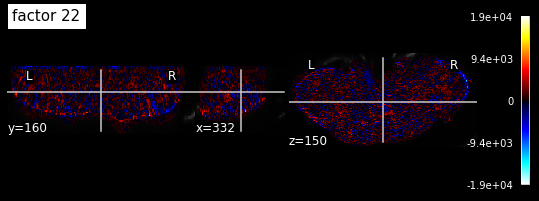

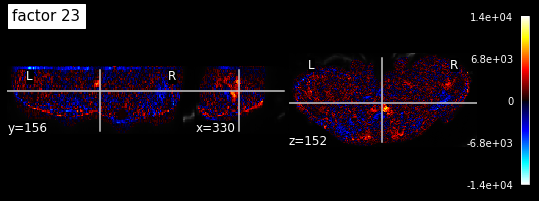

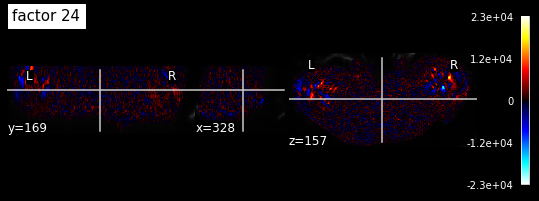

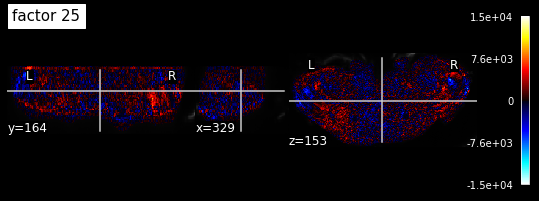

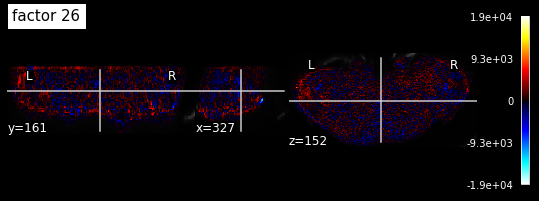

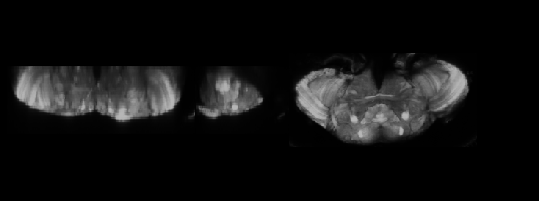

In [36]:
for idx in range(factors.shape[1]):
    tpimg = nib.Nifti1Image(np.zeros(maskimg.shape), maskimg.affine)
    tpimg.dataobj[maskvox] = factors[:, idx]
    nilearn.plotting.plot_stat_map(tpimg, bg_img=meanimg, title=f'factor {idx}')

In [32]:
meanimg = nib.load(meanfile)

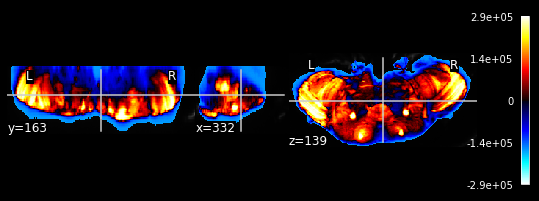